In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [2]:
table_desc = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/plots/SupTable_Sample_Stats_wGT_QC.tsv"
metadata_path = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"

metadata_table = pd.read_csv(table_desc, sep="\t")

metadata_20x_filt = metadata_table.loc[(metadata_table.finalQC != "fail")
                              & (metadata_table.cov_chrA >= 20)
                              & (metadata_table.remove_as_relative != True)
                              & (metadata_table.remove_manual != True)
                              & (~metadata_table.ID.str.startswith("SAMEA11633"))
                             ]

In [3]:
female_IDs = metadata_20x_filt.loc[metadata_20x_filt.gSEX == "F"].ID

In [4]:
df_l = []
for s in metadata_20x_filt.species_genotyping.unique():
    f_c = len(metadata_20x_filt.loc[metadata_20x_filt.gSEX == "F"])
    if f_c == 0:
        continue
    # Read het df
    het_df_path = "../results/window_stats_20x_inds/{}_100kb_het_hom.txt".format(s)
    if os.path.exists("../results/window_stats_20x_inds/{}_100kb_het_hom.txt".format(s)):
        het_df = pd.read_csv(het_df_path, sep="\t")
    else:
        print("Not present:", s)
        continue
    het_df = het_df.loc[het_df.GVCF_ID.isin(female_IDs) &
                        (het_df.callable_frac > 0.75) &
                       (~het_df.het.isna())]
    if sum(het_df.chr_type == "chrX") < 10 or sum(het_df.chr_type == "aut") < 10:
        print("Too little data", s)
        continue
    df_l.append(het_df)
all_het_df = pd.concat(df_l)

Too little data Aotus_griseimembra_ssp
Too little data Aotus_vociferans_ssp
Too little data Alouatta_caraya_ssp
Too little data Ateles_paniscus_ssp
Too little data Lagothrix_lagotricha_ssp
Too little data Callithrix_geoffroyi_ssp
Too little data Callithrix_kuhlii_ssp
Too little data Cebuella_pygmaea_ssp
Too little data Mico_humilis_ssp
Too little data Carlito_syrichta_ssp
Too little data Cephalopachus_bancanus_ssp
Too little data Tarsius_dentatus_ssp
Too little data Tarsius_lariang_ssp
Too little data Tarsius_wallacei_ssp
Too little data Cercopithecus_campbelli_ssp
Too little data Cercopithecus_cephus_ssp
Too little data Cercopithecus_diana_ssp
Too little data Cercopithecus_neglectus_ssp
Too little data Cercopithecus_nictitans_ssp
Too little data Cercopithecus_petaurista_ssp
Too little data Cercopithecus_pogonias_ssp
Too little data Allochrocebus_solatus_ssp
Too little data Chlorocebus_dryas_ssp
Too little data Chlorocebus_pygerythrus_ssp
Too little data Eulemur_coronatus_ssp
Too littl

In [5]:
all_het_df.species.unique(), len(all_het_df.species.unique())

(array(['Allenopithecus_nigroviridis_ssp', 'Aotus_azarai_ssp',
        'Aotus_nancymaae_ssp', 'Aotus_trivirgatus_ssp',
        'Alouatta_belzebul_ssp', 'Alouatta_discolor_ssp',
        'Alouatta_juara_ssp', 'Alouatta_macconnelli_ssp',
        'Alouatta_palliata_ssp', 'Alouatta_seniculus_ssp',
        'Ateles_belzebuth_ssp', 'Ateles_chamek_ssp',
        'Ateles_geoffroyi_ssp', 'Ateles_marginatus_ssp',
        'Brachyteles_hypoxanthus_ssp', 'Callimico_goeldii_ssp',
        'Callithrix_jacchus_ssp', 'Cebuella_niveiventris_ssp',
        'Mico_argentatus_ssp', 'Mico_humeralifer_ssp',
        'Cercopithecus_ascanius_ssp', 'Cercopithecus_denti_ssp',
        'Cercopithecus_hamlyni_ssp', 'Cercopithecus_mitis_ssp',
        'Cercopithecus_mona_ssp', 'Cercopithecus_roloway_ssp',
        'Cercopithecus_wolfi_ssp', 'Cheirogaleus_major_ssp',
        'Cheirogaleus_medius_ssp', 'Cheirogaleus_sibreei_ssp',
        'Allochrocebus_lhoesti_ssp', 'Allochrocebus_preussi_ssp',
        'Erythrocebus_patas_ssp'

[Text(0.5, 1.0, 'Heterozygosity per female individual'),
 (-0.01, 0.7083742527803523),
 (-0.01, 0.3996257215619694)]

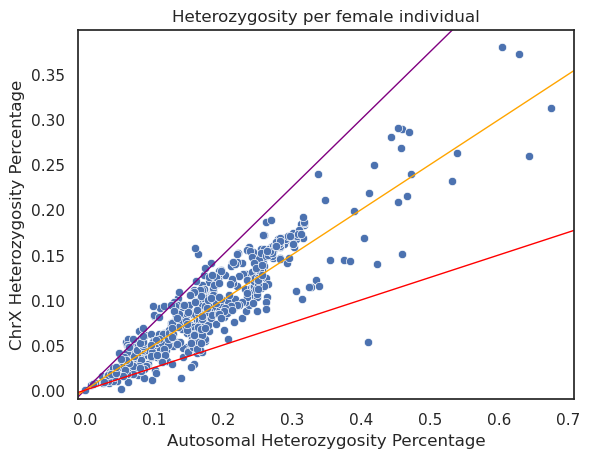

In [6]:
mean_het_df = all_het_df.groupby(["GVCF_ID","chr_type"])[["het"]].mean()
mean_het_df = mean_het_df.reset_index().pivot(columns="chr_type", index="GVCF_ID", values="het")
mean_het_df["Autosomal Heterozygosity Percentage"] = mean_het_df.aut/1000
mean_het_df["ChrX Heterozygosity Percentage"] = mean_het_df.chrX/1000
mean_het_df["X_a_ratio"] = mean_het_df.chrX/mean_het_df.aut
plt.axline((0, 0), slope=0.75, linewidth=1, color='purple')
plt.axline((0, 0), slope=0.5, linewidth=1, color='orange')
plt.axline((0, 0), slope=0.25, linewidth=1, color='red')
g = sns.scatterplot(mean_het_df, x="Autosomal Heterozygosity Percentage", y="ChrX Heterozygosity Percentage")
g.set(title="Heterozygosity per female individual", xlim=(-0.01, None), ylim=(-0.01, None))

In [7]:
len(mean_het_df.loc[mean_het_df.X_a_ratio < 0.5])/len(mean_het_df)

0.48665620094191525

[Text(0.5, 1.0, 'Mean across species'),
 (-0.01, 0.7083742527803523),
 (-0.01, 0.3996257215619694)]

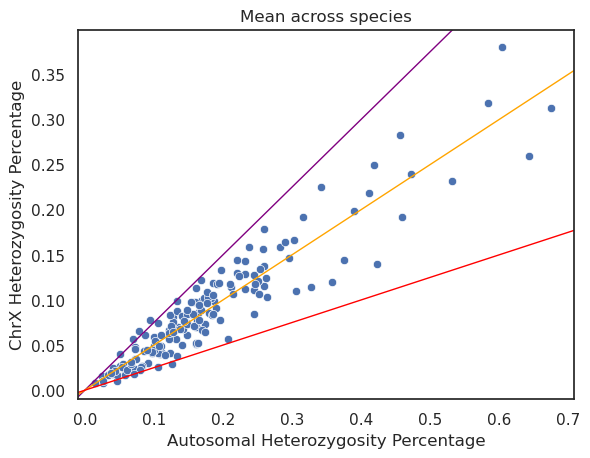

In [8]:
mean_het_df = all_het_df.groupby(["species","chr_type"])[["het"]].mean()
mean_het_df = mean_het_df.reset_index().pivot(columns="chr_type", index="species", values="het")
mean_het_df["Autosomal Heterozygosity Percentage"] = mean_het_df.aut/1000
mean_het_df["ChrX Heterozygosity Percentage"] = mean_het_df.chrX/1000
mean_het_df["X_a_ratio"] = mean_het_df.chrX/mean_het_df.aut
plt.axline((0, 0), slope=0.75, linewidth=1, color='purple')
plt.axline((0, 0), slope=0.5, linewidth=1, color='orange')
plt.axline((0, 0), slope=0.25, linewidth=1, color='red')
g = sns.scatterplot(mean_het_df, x="Autosomal Heterozygosity Percentage", y="ChrX Heterozygosity Percentage")
g.set(title="Mean across species", xlim=(-0.01, None), ylim=(-0.01, None))

In [9]:
mean_het_df.sort_values("aut")

chr_type,aut,chrX,Autosomal Heterozygosity Percentage,ChrX Heterozygosity Percentage,X_a_ratio
species,,,,,
Rhinopithecus_strykeri_ssp,14.558112,7.885502,0.014558,0.007886,0.541657
Alouatta_palliata_ssp,24.490848,16.175549,0.024491,0.016176,0.660473
Trachypithecus_poliocephalus_ssp,25.724771,10.423667,0.025725,0.010424,0.405200
Semnopithecus_schistaceus_ssp,25.959872,7.665605,0.025960,0.007666,0.295287
Macaca_sylvanus_ssp,33.929391,17.055634,0.033929,0.017056,0.502680
...,...,...,...,...,...
Microcebus_griseorufus_ssp,532.530970,231.654279,0.532531,0.231654,0.435006
Cercopithecus_ascanius_ssp,583.829628,317.898616,0.583830,0.317899,0.544506
Eulemur_fulvus_ssp,604.850640,380.595925,0.604851,0.380596,0.629240


<Axes: xlabel='Autosomal Heterozygosity Percentage', ylabel='X_a_ratio'>

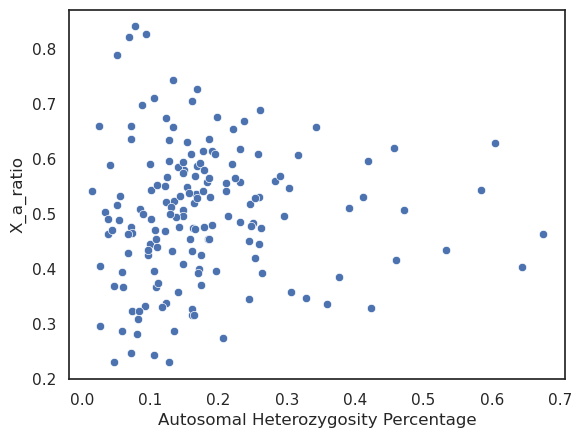

In [10]:
mean_het_df = all_het_df.groupby(["species","chr_type"])[["het"]].mean()
mean_het_df = mean_het_df.reset_index().pivot(columns="chr_type", index="species", values="het")
mean_het_df["X_a_ratio"] = mean_het_df.chrX/mean_het_df.aut
mean_het_df["Autosomal Heterozygosity Percentage"] = mean_het_df.aut/1000
mean_het_df["ChrX Heterozygosity Percentage"] = mean_het_df.chrX/1000
sns.scatterplot(mean_het_df, x="Autosomal Heterozygosity Percentage", y="X_a_ratio")

In [11]:
mean_het_df.loc[mean_het_df.aut >= 200].sort_values("X_a_ratio")

chr_type,aut,chrX,X_a_ratio,Autosomal Heterozygosity Percentage,ChrX Heterozygosity Percentage
species,,,,,
Mandrillus_leucophaeus_ssp,207.198946,56.650522,0.273411,0.207199,0.056651
Hapalemur_griseus_ssp,423.731359,139.585284,0.329419,0.423731,0.139585
Microcebus_murinus_ssp,358.034043,120.466370,0.336466,0.358034,0.120466
Allochrocebus_lhoesti_ssp,245.223563,84.792816,0.345778,0.245224,0.084793
Cheirogaleus_sibreei_ssp,327.763618,114.029605,0.347902,0.327764,0.114030
Propithecus_diadema_ssp,305.475549,109.420228,0.358196,0.305476,0.109420
Eulemur_sanfordi_ssp,375.808813,144.832168,0.385388,0.375809,0.144832
Allochrocebus_preussi_ssp,264.111020,103.444526,0.391671,0.264111,0.103445
Eulemur_rufifrons_ssp,643.653457,259.134549,0.402599,0.643653,0.259135


<Axes: xlabel='X_a_ratio', ylabel='Count'>

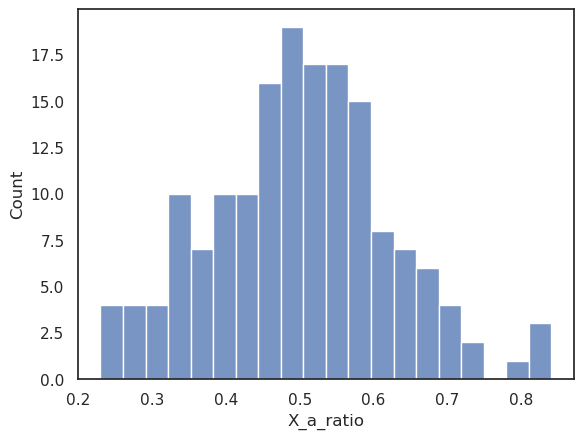

In [12]:
sns.histplot(mean_het_df.X_a_ratio, bins=20)

In [13]:
mean_het_df.X_a_ratio.mean(), mean_het_df.X_a_ratio.median()

(0.5001628216208978, 0.49935121670950766)

In [14]:
mating_vas = pd.read_excel("../data/PrimatePhenotypes_august.xlsx", sheet_name=8)
mating_vas

,binomial_name,Monogamous,Polygynous,Polygynandrous,Polyandrous,lowSC,highSC,consensus,comment,Juliana_Christina,genus_comment
0,Allenopithecus_nigroviridis,0,0,1,0,0,1,Polygynandrous,NaN,NaN,NaN
1,Allocebus_trichotis,2,1,0,0,3,0,Monogamous,NaN,NaN,NaN
2,Allochrocebus_lhoesti,0,3,0,0,3,0,Polygynous,NaN,NaN,NaN
3,Allochrocebus_preussi,0,1,0,0,1,0,Polygynous,NaN,NaN,NaN
4,Allochrocebus_solatus,0,1,0,0,1,0,Polygynous,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
311,Trachypithecus_phayrei,0,2,1,0,2,1,NaN,conflicting,NaN,NaN
312,Trachypithecus_pileatus,0,2,0,0,2,0,Polygynous,NaN,NaN,NaN
313,Trachypithecus_selangorensis,0,1,0,0,1,0,Polygynous,NaN,NaN,NaN
314,Varecia_rubra,0,1,1,0,1,1,NaN,conflicting,NaN,NaN


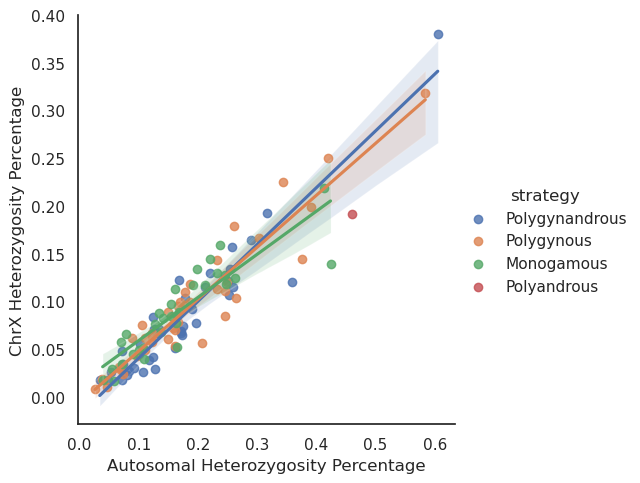

In [15]:
mean_het_df["binomial_name"] = [x[:-4] for x in mean_het_df.index]
mean_het_df["strategy"] = mean_het_df.binomial_name.map(dict(zip(mating_vas.binomial_name, mating_vas.consensus)))
sns.lmplot(mean_het_df, x="Autosomal Heterozygosity Percentage", y="ChrX Heterozygosity Percentage", hue="strategy")

In [16]:
mean_het_df

chr_type,aut,chrX,X_a_ratio,Autosomal Heterozygosity Percentage,ChrX Heterozygosity Percentage,binomial_name,strategy
species,,,,,,,
Allenopithecus_nigroviridis_ssp,134.758691,70.528388,0.523368,0.134759,0.070528,Allenopithecus_nigroviridis,Polygynandrous
Allochrocebus_lhoesti_ssp,245.223563,84.792816,0.345778,0.245224,0.084793,Allochrocebus_lhoesti,Polygynous
Allochrocebus_preussi_ssp,264.111020,103.444526,0.391671,0.264111,0.103445,Allochrocebus_preussi,Polygynous
Alouatta_belzebul_ssp,185.969334,118.393756,0.636631,0.185969,0.118394,Alouatta_belzebul,Polygynous
Alouatta_discolor_ssp,186.911969,99.393909,0.531769,0.186912,0.099394,Alouatta_discolor,Polygynous
...,...,...,...,...,...,...,...
Trachypithecus_pileatus_ssp,110.616756,61.087930,0.552248,0.110617,0.061088,Trachypithecus_pileatus,Polygynous
Trachypithecus_poliocephalus_ssp,25.724771,10.423667,0.405200,0.025725,0.010424,Trachypithecus_poliocephalus,NaN
Trachypithecus_vetulus_ssp,223.515920,126.429352,0.565639,0.223516,0.126429,Trachypithecus_vetulus,NaN


In [17]:
all_het_df.groupby(["species","chr_type", "chrom"])[["het"]].transform(pd.qcut,2, duplicates="drop")

,het
2646,"(67.0, 349.0]"
2647,"(67.0, 349.0]"
2648,"(67.0, 349.0]"
2649,"(67.0, 349.0]"
2650,"(67.0, 349.0]"
...,...
37278,"(109.5, 600.0]"
37279,"(109.5, 600.0]"
37280,"(109.5, 600.0]"
37281,"(-0.001, 109.5]"


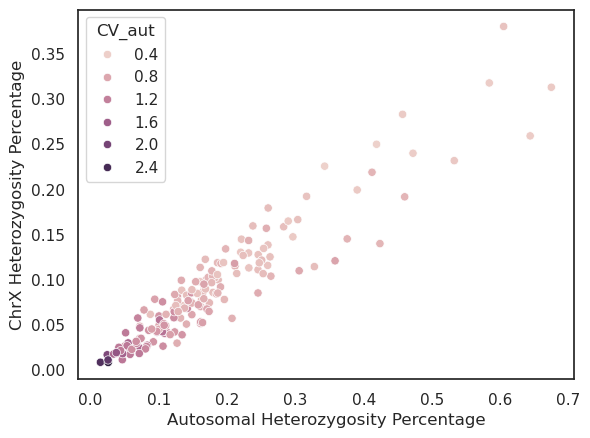

In [18]:
all_het_df_aut = all_het_df.loc[all_het_df.chr_type == "aut"]
mean_het_df = mean_het_df.reset_index()
mean_het_df["CV_aut"] = (all_het_df_aut.groupby(["species"])[["het"]].std() / all_het_df_aut.groupby(["species"])[["het"]].mean()).reset_index()["het"]

mean_het_df["Autosomal Heterozygosity Percentage"] = mean_het_df.aut/1000
mean_het_df["ChrX Heterozygosity Percentage"] = mean_het_df.chrX/1000
mean_het_df["X_a_ratio"] = mean_het_df.chrX/mean_het_df.aut
g = sns.scatterplot(mean_het_df, x="Autosomal Heterozygosity Percentage", y="ChrX Heterozygosity Percentage", hue="CV_aut")